# CPE 490 590 
# Gaussian Mixture Modeling (GMM)
## Author: Rahul Bhadani

## GMM as a better version of K-means

The k-means model can be conceptualized as placing a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster. The radius of this circle is determined by the most distant point within the cluster. This radius serves as a strict boundary for assigning data points to the cluster during training: any point outside this circle is not considered a part of the cluster. To visualize this cluster model, we can use the following function:

### Generate some data

In [59]:
# Generate some data
from sklearn.datasets import make_blobs
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np                ## linear algebra
import pandas as pd               ## data processing, dataset file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   ## data visualization & graphical plotting
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.70, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

In [60]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, edgecolors='black')

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

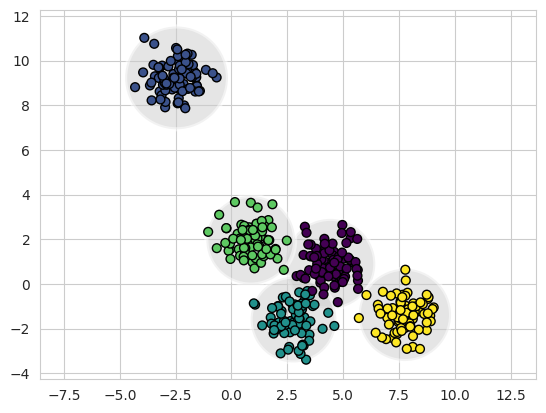

In [61]:
kmeans = KMeans(n_clusters=5, random_state=0)
plot_kmeans(kmeans, X)

## An important observation for k-means is that these cluster models must be circular: 
### k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

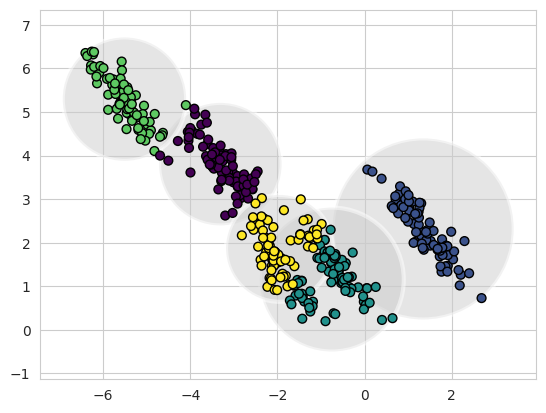

In [62]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=5, random_state=0)
plot_kmeans(kmeans, X_stretched)

### By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.

# Gaussian Mixture Models
A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

In [80]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=5).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', edgecolors='black');

AttributeError: module 'sklearn.mixture' has no attribute 'GMM'

### But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments


In [64]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[1.    0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.999 0.    0.    0.001]
 [0.    0.    0.    1.    0.   ]]


### We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

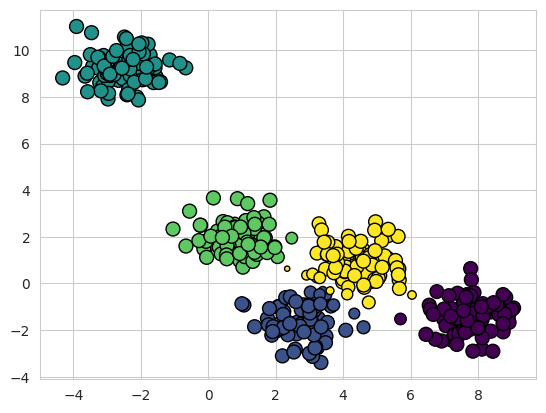

In [65]:
size = 100 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size, edgecolors='black');

## GMM uses Expectation-Maximization
### Choose starting guesses for the location and shape
### Repeat until converged:
- E-step: for each point, find weights encoding the probability of membership in each cluster
- M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

### The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

### Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [66]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, edgecolors='black')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, edgecolors='black')
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

/tmp/ipykernel_22213/3782685461.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


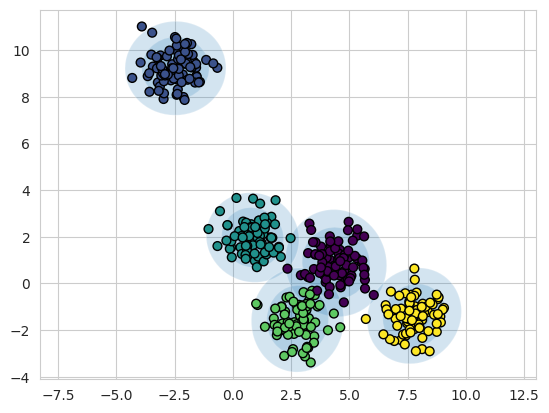

In [67]:
gmm = GMM(n_components=5, random_state=42)
plot_gmm(gmm, X)

### Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

/tmp/ipykernel_22213/3782685461.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


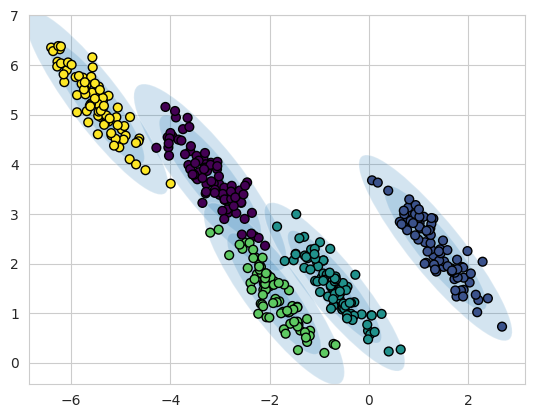

In [68]:
gmm = GMM(n_components=5, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

### This demonstrates the GMM is better than K-means

# GMM as Density Estimation

### Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.



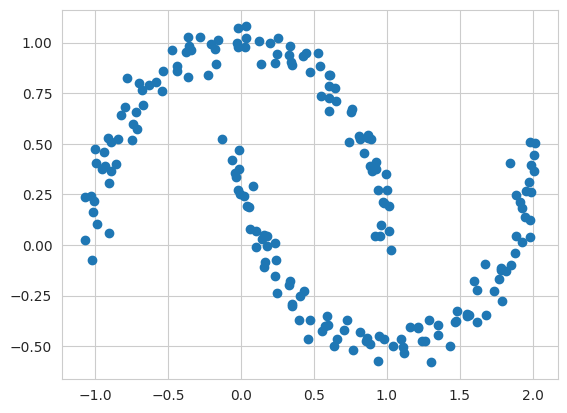

In [69]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

### If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

/tmp/ipykernel_22213/3782685461.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


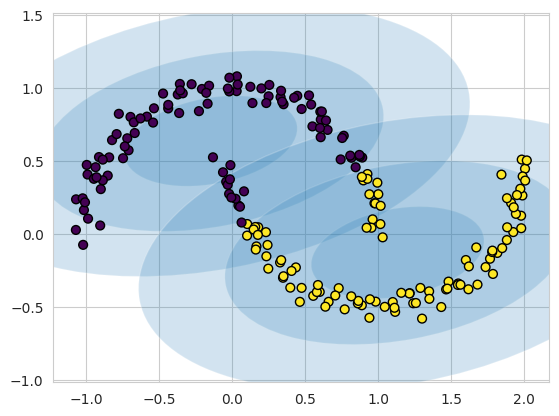

In [70]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

## But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

/tmp/ipykernel_22213/3782685461.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


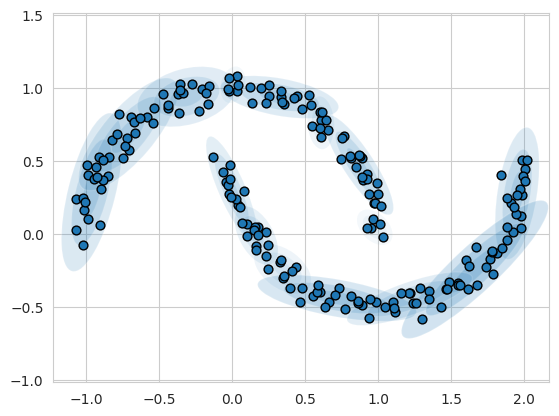

In [83]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

### Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

/tmp/ipykernel_22213/1772006041.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Xnew[:, 0], Xnew[:, 1], s=40, cmap='viridis', zorder=2, edgecolors='black')


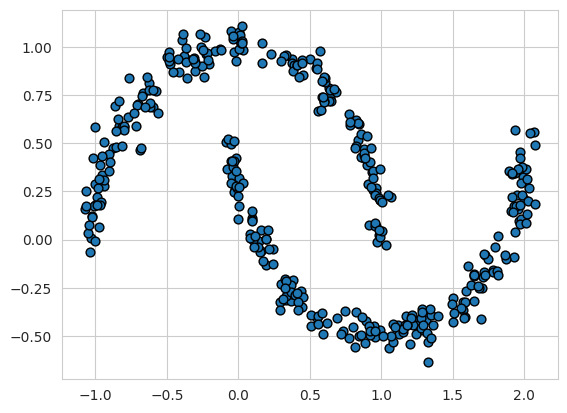

In [86]:
Xnew, _ = gmm16.sample(400)  # Extract the samples (ignore the cluster labels)
plt.scatter(Xnew[:, 0], Xnew[:, 1], s=40, cmap='viridis', zorder=2, edgecolors='black')